In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%config InlineBackend.figure_format = 'retina'

# streamlined visualization

In [2]:
directory = r"\\wsl$\Ubuntu-18.04\home\arlenlex\LIGGGHTS_SEAICE\lexi_tests\bond_tension\post"
log_file_path = r"\\wsl$\Ubuntu-18.04\home\arlenlex\LIGGGHTS_SEAICE\lexi_tests\bond_tension\log.liggghts"

In [3]:
def get_dt(log_file_path):
    # Open and read the log file
    with open(log_file_path, 'r') as file:
        lines = file.readlines()
        dt = None

        for i, line in enumerate(lines):
            if (line.strip().startswith('Step    Atoms numbonds             Dt')): 
                # Extract Dt from the first step line after 'Memory used'
                parts = lines[i+1].split()
                dt = parts[-1]  # Assuming Dt is always the last element
                break
    if dt == None:
        raise ValueError('No step size found')
    else:
        return float(dt)   

In [4]:
dt = get_dt(log_file_path)

In [5]:
def create_bond_df(directory):
    '''
    Function for parsing LIGGGHTS bond files. 
    Computes bond force magnitude (b_fmag) in addition to other variables.
    Organizes data so that df['bfx'] gives an array of values across all timesteps.
    '''
    bond_variable_names = ["x1", "y1", "z1", "x2", "y2", "z2",
                           "batom1", "batom2", "btype", "bfx", "bfy", "bfz",
                           "btx", "bty", "btz", "beqdist"] 

    # Initialize a dictionary to store lists for each variable, including b_fmag
    data_dict = {var: [] for var in bond_variable_names}
    data_dict['b_fmag'] = []
    timesteps = []

    fpaths = sorted(glob.glob(directory + r'\*.bond'))

    # Loop over all files in the directory
    for fname in fpaths:
            
        # Open and read the file
        with open(fname, 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)

            # Extract the data line; data is on the last line
            data_line = lines[-1]
            vals = list(map(float, data_line.split()))
            
            # Store each data value under its corresponding variable name
            for i, var in enumerate(bond_variable_names):
                data_dict[var].append(vals[i])

            # Calculate the force magnitude (b_fmag) and store it
            bfx, bfy, bfz = vals[9], vals[10], vals[11]
            bond_force_magnitude = np.sqrt(bfx**2 + bfy**2 + bfz**2)
            data_dict['b_fmag'].append(bond_force_magnitude)
                    
    # Create a DataFrame where each column contains an array of values across timesteps
    df = pd.DataFrame({var: pd.Series(data_dict[var], index=timesteps) for var in data_dict})
    
    return df


In [6]:
df_bond = create_bond_df(directory)

In [7]:
def create_atom_df(directory):
    atom_variable_names = ['id', 'atype', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'fx',
                            'fy', 'fz', 'omegax', 'omegay', 'omegaz', 'radius']
    
    # Initialize a dictionary to store DataFrames for each atom ID
    atom_data = {}
    timesteps = []

    fpaths = sorted(glob.glob(directory + r'\*.liggghts'))

    # Loop over all dump files in the simulation directory
    for fname in fpaths:
        # Open and read the file
        with open(fname, 'r') as file:
            lines = file.readlines()
            
            # Extract the timestep; on the second line
            timestep = int(lines[1].strip())
            timesteps.append(timestep)
            
            # Extract the number of atoms; on the fourth line
            num_atoms = int(lines[3].strip())
            
            # Extract the atom data starting from the ninth line
            for i in range(num_atoms):
                data_line = lines[9 + i].strip()
                vals = list(map(float, data_line.split()))
                
                # Atom ID is the first value in the data line
                atom_id = int(vals[0])
                
                # Calculate the force magnitude for the atom
                fx, fy, fz = vals[8], vals[9], vals[10]
                atom_force_magnitude = np.sqrt(fx**2 + fy**2 + fz**2)
                
                # Add force magnitude to the list of variables
                vals.append(atom_force_magnitude)
                
                # If the atom ID doesn't have a DataFrame yet, create one
                if atom_id not in atom_data:
                    atom_data[atom_id] = {var: [] for var in atom_variable_names + ['atom_fmag']}
                    atom_data[atom_id]['timestep'] = []
                
                # Append the values for this timestep
                for j, var in enumerate(atom_variable_names + ['atom_fmag']):
                    atom_data[atom_id][var].append(vals[j])
                atom_data[atom_id]['timestep'].append(timestep)

    # Convert each atom's dictionary into a DataFrame and store in a new dictionary
    atom_dfs = {}
    for atom_id, data_dict in atom_data.items():
        atom_dfs[atom_id] = pd.DataFrame(data_dict).set_index('timestep')
    
    # Concatenate the atom DataFrames into a MultiIndex DataFrame
    final_df = pd.concat(atom_dfs, axis=1)
    
    return final_df


In [8]:
df_atom = create_atom_df(directory)

# plot

In [9]:
def plot_relevant_quantities(df_atom, df_bond, dt, simulation_num):
    fig, axes = plt.subplots(2,2, layout = 'constrained', sharex=True, figsize = (8,6))
    ax = axes.flatten()

    fig.suptitle(f'simulation: {simulation_num}')

    plt.sca(ax[0])
    id = 1
    plt.plot(df_atom.index.values * dt, df_atom[id]['atom_fmag'], 'o-', color = 'r', lw = 0.5, markersize = 1, label = f'id = {id}')
    id = 2
    plt.plot(df_atom.index.values * dt, df_atom[id]['atom_fmag'], 'o-', color = 'b', lw = 0.5, markersize = 1, label = f'id = {id}')
    plt.ylabel(r'$|F_a|$ [N]')
    plt.grid(True)
    plt.legend()

    plt.sca(ax[1])
    id = 1
    plt.plot(df_atom.index.values * dt, df_atom[id]['x'].values - df_atom[id]['x'].values[0], 'o-', color = 'r', lw = 0.5, markersize = 1, label = f'id = {id}')
    id = 2
    plt.plot(df_atom.index.values * dt, df_atom[id]['x'].values - df_atom[id]['x'].values[0], 'o-', color = 'b', lw = 0.5, markersize = 1, label = f'id = {id}')
    plt.ylabel(r'$\Delta x$ [m]')
    plt.grid(True)
    plt.legend()

    plt.sca(ax[2])
    id = 1
    plt.plot(df_atom.index.values * dt, np.abs(df_atom[id]['vx'].values), 'o-', color = 'r', lw = 0.5, markersize = 1, label = f'id = {id}')
    id = 2
    plt.plot(df_atom.index.values * dt, np.abs(df_atom[id]['vx'].values) , 'o-', color = 'b', lw = 0.5, markersize = 1, label = f'id = {id}')
    plt.ylabel(r'$|v_x|$ [m/s]')
    plt.grid(True)
    plt.legend()

    plt.sca(ax[3])
    plt.plot(df_bond.index.values * dt, df_bond['b_fmag'].values, 'o-', color = 'k', lw = 0.5, markersize = 1)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$|F_b|$ [N]')
    plt.grid(True)

    plt.close()

    return fig

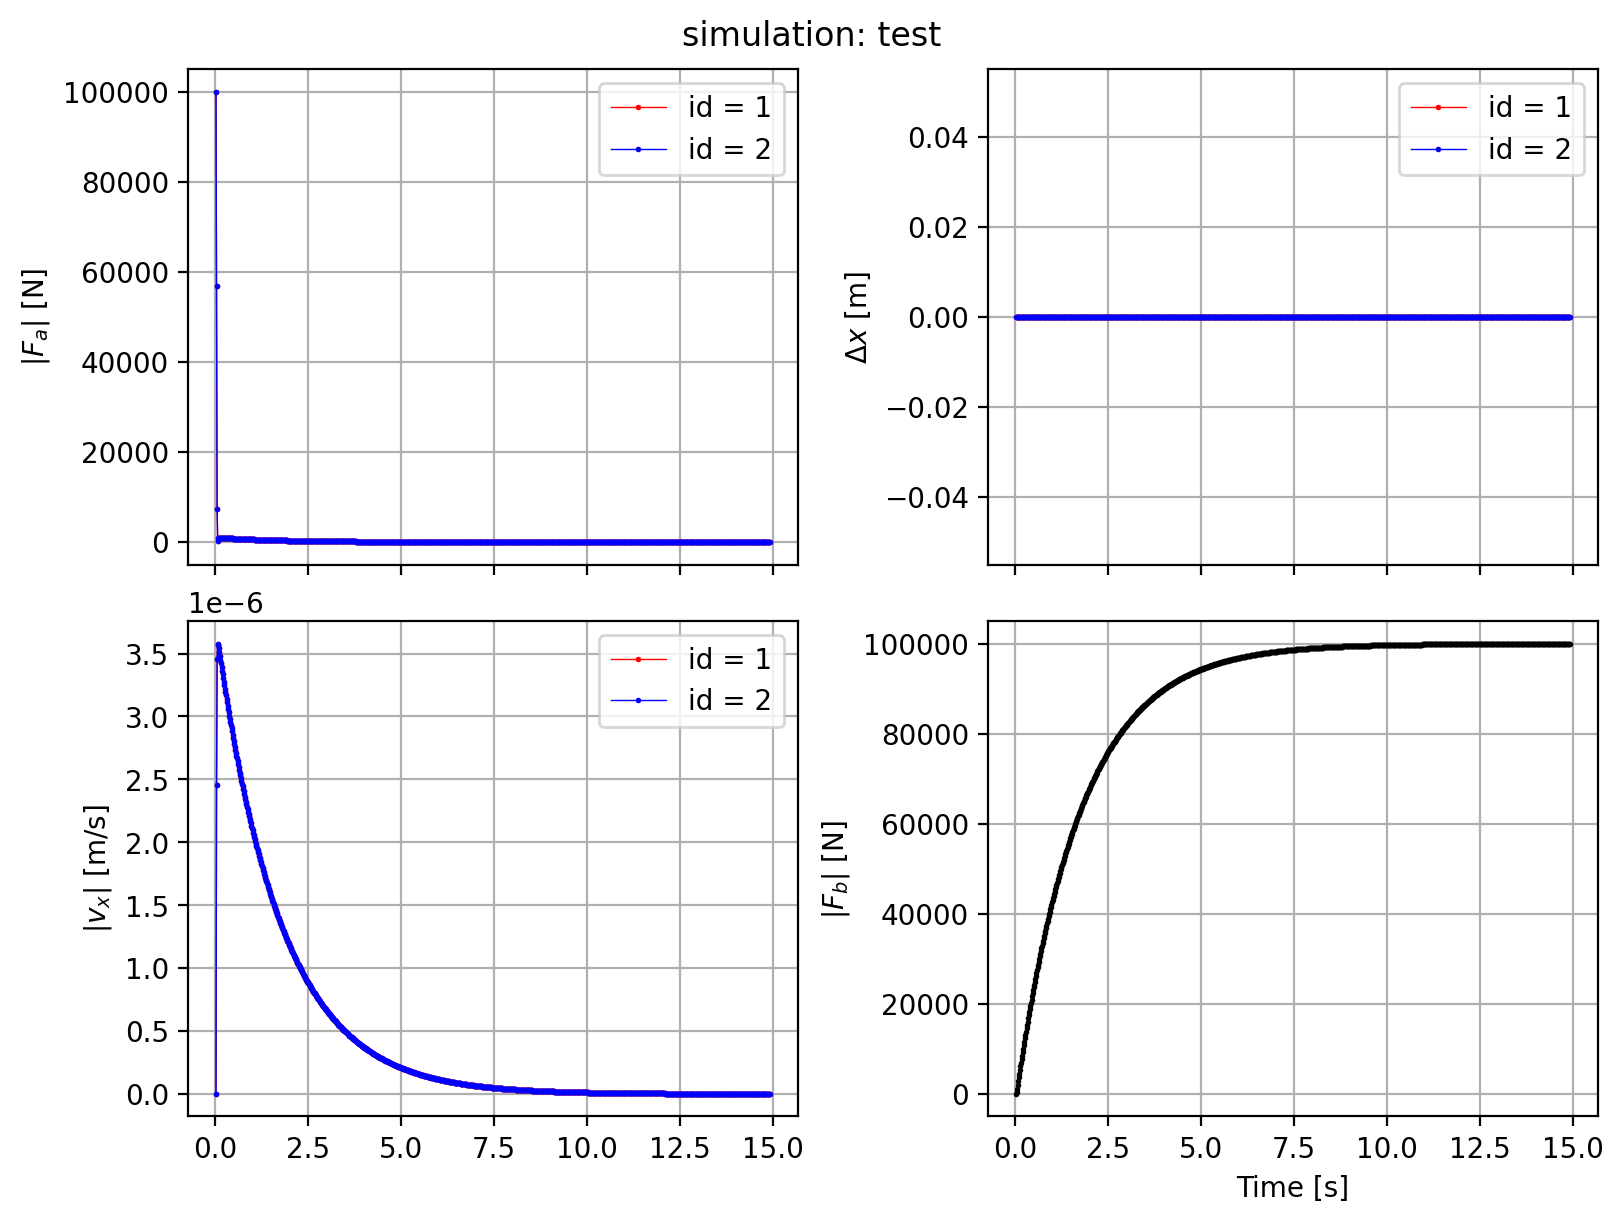

In [10]:
plot_relevant_quantities(df_atom, df_bond, dt, 'test')

# scripting

# for directory in directories
simulation_num = # get title from directory name
dta, df_atom = create_atom_df(directory)
dtb, df_bond = create_bond_df(directory)
if dta != dtb:
    raise ValueError("Bond & atom timesteps are different.")
    #break
plot_relevant_quantities(df_atom, df_bond, dt, simulation_num)
